In [1]:
#%matplotlib inline
#%matplotlib gtk
import sys
sys.path.insert(0, '../')
from pytest import approx
import fconcrete as fc
#import fconcrete
#from fconcrete import helpers, duplicated, Material, e, Beam, Node, Loads, Nodes, Load,Material, ConcreteBeam, SingleBeamElement, Rectangle, Concrete, Section, ConcreteSteels
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=3, suppress=True, linewidth=3000)

#from math import log

# Tension in MPa
# length in cm
# Shear in kN

entrou


In [2]:
material = fc.Concrete(fck='20 MPa', aggressiveness=2)
section = fc.Rectangle(25,56, material)

f1 = fc.Load.UniformDistributedLoad(-0.1622, x_begin=0, x_end=113)
f2 = fc.Load.UniformDistributedLoad(-0.4994, x_begin=113, x_end=583)
f3 = fc.Load.UniformDistributedLoad(-0.4196, x_begin=583, x_end=1188)

n1 = fc.Node.SimpleSupport(x=0)
n2 = fc.Node.SimpleSupport(x=113)
n3 = fc.Node.SimpleSupport(x=583)
n4 = fc.Node.SimpleSupport(x=1188)

bar1 = fc.SingleBeamElement([n1, n2], section)
bar2 = fc.SingleBeamElement([n2, n3], section)
bar3 = fc.SingleBeamElement([n3, n4], section)

fc.config.available_material = {
"concrete_steel_bars":fc.AvailableConcreteSteelBar(
        diameters=[8]
)}
    
beam = fc.ConcreteBeam(
    loads = [f1, f2, f3],
    bars = [bar1, bar2, bar3],
    remove_steel_jump = 2
)
self = beam

In [3]:
beam.steel_bars

[{'long_begin': -25.310800830830832, 'long_end': 200.12162869869871, 'quantity': 2, 'diameter': -0.8, 'area': -1.0}
 {'long_begin': 34.14865762762763, 'long_end': 168.01352113113114, 'quantity': 3, 'diameter': -0.8, 'area': -1.5}
 {'long_begin': 59.45946845845846, 'long_end': 154.25676371371372, 'quantity': 4, 'diameter': -0.8, 'area': -2.0}
 {'long_begin': 83.24325184184184, 'long_end': 141.17568285285284, 'quantity': 5, 'diameter': -0.8, 'area': -2.5}
 {'long_begin': 148.31081786786788, 'long_end': 454.6081109009009, 'quantity': 2, 'diameter': 0.8, 'area': 1.0}
 {'long_begin': 191.45946623623624, 'long_end': 411.12162425425424, 'quantity': 3, 'diameter': 0.8, 'area': 1.5}
 {'long_begin': 226.28379042042042, 'long_end': 376.12162573573573, 'quantity': 4, 'diameter': 0.8, 'area': 2.0}
 {'long_begin': 402.79730007007004, 'long_end': 733.7297273773773, 'quantity': 2, 'diameter': -0.8, 'area': -1.0}
 {'long_begin': 402.79730007007004, 'long_end': 733.7297273773773, 'quantity': 2, 'diamete

In [10]:
steel_bars = SteelBars(beam.steel_bars.steel_bars)

In [11]:
steel_bars

[{'long_begin': -25.310800830830832, 'long_end': 200.12162869869871, 'quantity': 2, 'diameter': -0.8, 'area': -1.0}
 {'long_begin': 34.14865762762763, 'long_end': 168.01352113113114, 'quantity': 3, 'diameter': -0.8, 'area': -1.5}
 {'long_begin': 59.45946845845846, 'long_end': 154.25676371371372, 'quantity': 4, 'diameter': -0.8, 'area': -2.0}
 {'long_begin': 83.24325184184184, 'long_end': 141.17568285285284, 'quantity': 5, 'diameter': -0.8, 'area': -2.5}
 {'long_begin': 148.31081786786788, 'long_end': 454.6081109009009, 'quantity': 2, 'diameter': 0.8, 'area': 1.0}
 {'long_begin': 191.45946623623624, 'long_end': 411.12162425425424, 'quantity': 3, 'diameter': 0.8, 'area': 1.5}
 {'long_begin': 226.28379042042042, 'long_end': 376.12162573573573, 'quantity': 4, 'diameter': 0.8, 'area': 2.0}
 {'long_begin': 402.79730007007004, 'long_end': 733.7297273773773, 'quantity': 2, 'diameter': -0.8, 'area': -1.0}
 {'long_begin': 402.79730007007004, 'long_end': 733.7297273773773, 'quantity': 2, 'diamete

In [8]:
class SteelBars():
    def __init__(self, steel_bars=[], remove_steel_jump=2):
        self.steel_bars = np.array(steel_bars)
    
    def add(self, steelbar):
        if str(type(steelbar)) == "<class 'fconcrete.SteelBar.SteelBars'>":
            concatenation = list(np.concatenate((self.steel_bars,steelbar.steel_bars)))
            concatenation.sort(key=lambda x: x.long_begin, reverse=False)
            self.steel_bars = np.array(concatenation)
            
        elif str(type(steelbar)) == "<class 'fconcrete.SteelBar.SteelBar'>":
            self.steel_bars = np.append(self.steel_bars,steelbar)
    
    def plot(self,prop='quantity'):
        for steelbar in self.steel_bars:
            steelbar.plot(prop)
    
    def __getitem__(self, key):
        return self.steel_bars[key]
    
    def __repr__(self):
        return str(self.steel_bars)

In [ ]:
steel_bars

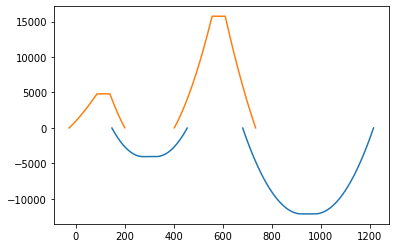

In [3]:
x_decalaged, momentum_positive, momentum_negative = beam.getDecalagedMomentumDiagram()
plt.plot(x_decalaged, -momentum_positive)
plt.plot(x_decalaged, -momentum_negative)

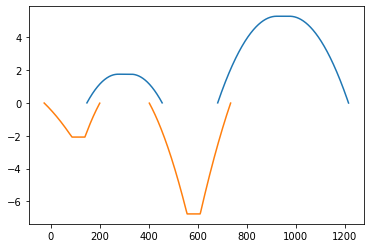

In [5]:
x, yp, yn = beam.getSteelAreaDiagram()
plt.plot(x, yp)
plt.plot(x, yn)

# Rascunho

In [6]:
quantity_positive, diameter_positive, area_positive = positive_areas_info

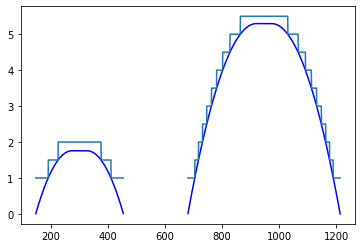

In [8]:
x, yp, yn = beam.getSteelAreaDiagram()
plt.plot(x, yp, 'b-')
plt.plot(x, area_positive)

In [4]:
x, positive_areas_info, negative_areas_info = self.getComercialSteelAreaDiagram()

In [5]:
quantities, diameters, areas = negative_areas_info

In [8]:
np.unique(areas)

array([-7. , -6.5, -6. , ...,  nan,  nan,  nan])

In [25]:
diameters=[8]
diameters_to_area={
    5: 0.2,
    6.3: 0.315,
    8: 0.5,
    10: 0.8,
    12.5: 1.25,
    16: 2,
    20: 3.15,
    25: 5,
    32: 8,
    40: 12.5
}
max_number=5
    
diameters = np.array(diameters)
areas = np.array(areas)
diameters_loop = np.tile(diameters/10, max_number-1)
areas_loop = np.concatenate([ areas*(i) for i in range(2, max_number+1)])
number_of_bars = areas_loop/np.tile(areas,max_number-1)
table_of_positive_steel = np.stack((number_of_bars, diameters_loop, areas_loop), axis=1)

ValueError: all input arrays must have the same shape

In [28]:
len(diameters_loop)

4

In [ ]:





table_of_negative_steel = -np.array(table_of_positive_steel)
table_of_positive_and_negative_steel = np.vstack([table_of_negative_steel, table_of_positive_steel])
table = np.array(table_of_positive_and_negative_steel[
    table_of_positive_and_negative_steel[:,2].argsort()
])

In [9]:
def _getBarsInInterspaces(self, x, areas_info):
    quantities, diameters, areas = areas_info  
    bars = SteelBars()
    for interspace in self._getInterspaceBetweenMomentum(x, areas):
        is_in_interpace = (x > interspace[0]) & (x<interspace[1])
        x_interspace = x[is_in_interpace]
        quantities_interspace = quantities[is_in_interpace]
        diameter = diameters[is_in_interpace][0]

        max_quantity_interspace = int(max(quantities_interspace))

        for quantity in range(1, max_quantity_interspace+1):
            x_same_quantity = x_interspace[quantities_interspace == quantity]
            if len(x_same_quantity)>0:
                new_bar = SteelBar(long_begin=min(x_same_quantity),
                                long_end=max(x_same_quantity),
                                quantity=quantity,
                                diameter=diameter)
                bars.add(new_bar)

    return bars

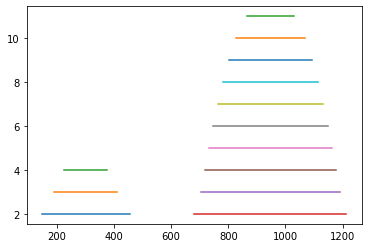

In [13]:
getBarsInInterspaces(x, positive_areas_info).plot()


In [69]:
new_bar = SteelBar(long_begin=0,
                                   long_end=2,
                                   quantity=5,
                                   diameter=0.1)

In [77]:
getattr(new_bar, 'quantity')

5

In [72]:
new_bar['quantity']

TypeError: 'SteelBar' object is not subscriptable

In [71]:
new_bar.plot()

TypeError: 'SteelBar' object is not subscriptable

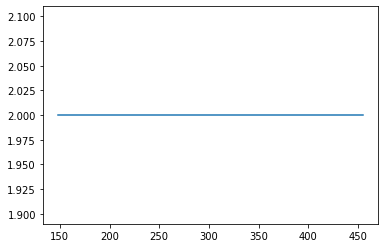

In [27]:
plt.plot([148.311,454.608], [2, 2])

In [13]:
yp[np.isnan(yp)]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan

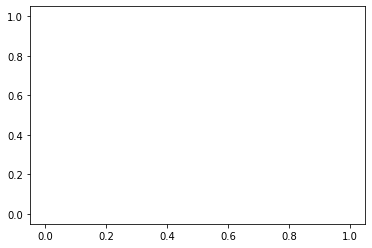

In [11]:
a = x[np.isnan(yp)]
b = yp[np.isnan(yp)]
plt.plot(a, b)

In [80]:
yp[np.isnan(yp)]

TypeError: only integer scalar arrays can be converted to a scalar index

In [49]:
number_of_bars[~np.isnan(number_of_bars)]

array([2., 2., 2., ..., 2., 2., 2.])

In [51]:
bar_removal = number_of_bars.copy()
for number in np.unique(number_of_bars[~np.isnan(number_of_bars)]):
    bar_removal = np.vstack([bar_removal, number*(number_of_bars==number)])
bar_removal = bar_removal[1:]

In [52]:
bar_removal = np.where(bar_removal==0, np.nan, bar_removal)

In [53]:
bar_removal

array([[nan, nan, nan, ...,  2.,  2.,  2.],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

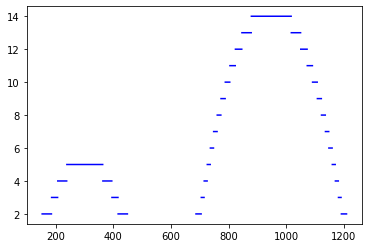

In [54]:
for bar in bar_removal:
    plt.plot(x, bar, 'b')
    
plt.show()

In [57]:
a = np.array([1, 2, 4])
a1 = np.vstack([a, [5,6,6]])
a2 = np.vstack([a1, [5,6,6]])

In [55]:
a2

array([[1, 2, 4],
       [5, 6, 6],
       [5, 6, 6]])

In [35]:
np.array([np.array([[1,2,3],[4,5,6]]),np.array([5,7,8])])

array([array([[1, 2, 3],
       [4, 5, 6]]), array([5, 7, 8])], dtype=object)

In [55]:
x, necessary_area = beam.getSteelAreaDiagram()
x, y = beam.getComercialSteelAreaDiagram()
number_of_bars = np.array(y)[:,0]
bar_diameter = np.array(y)[:,1]
comercial_area = np.array(y)[:,2]

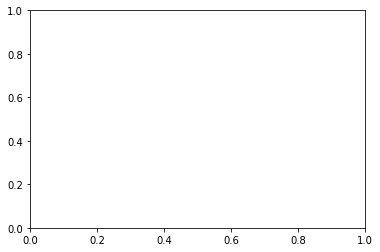

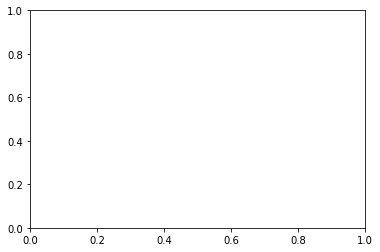

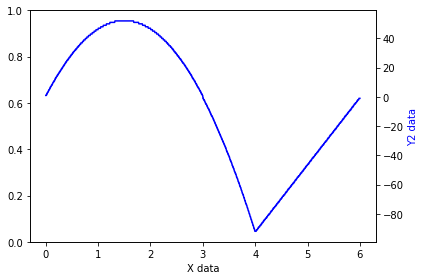

In [69]:
plt.cla()
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
#ax1.plot(x, comercial_area, 'g-')
ax2.plot(x, number_of_bars, 'b-')

ax1.set_xlabel('X data')
#ax1.set_ylabel('Y1 data', color='g')
ax2.set_ylabel('Y2 data', color='b')


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [7]:
gapminder_us = gapminder[gapminder.country=="United States"]

Text(0,0.5,'Y2 data')

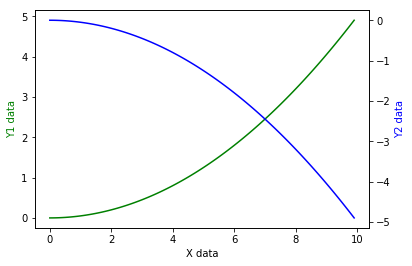

In [49]:
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(0, 10, 0.1)
y1 = 0.05 * x**2
y2 = -1 *y1

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-')

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data', color='g')
ax2.set_ylabel('Y2 data', color='b')

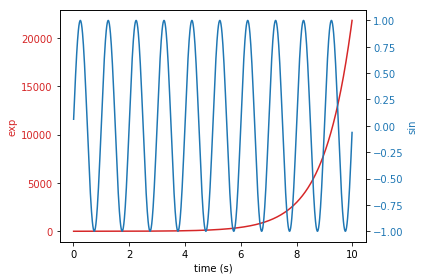

In [67]:
import matplotlib.pyplot as plt

# Create some mock data
t = np.arange(0.01, 10.0, 0.01)
data1 = np.exp(t)
data2 = np.sin(2 * np.pi * t)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('exp', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
